In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from tabulate import tabulate

# raw data

In [2]:
datapoints = pd.read_csv("mossbauer-mode-peaks-0123.csv",header=19)
counts = datapoints['Counts'].tolist()
channels = datapoints['Channel'].tolist()

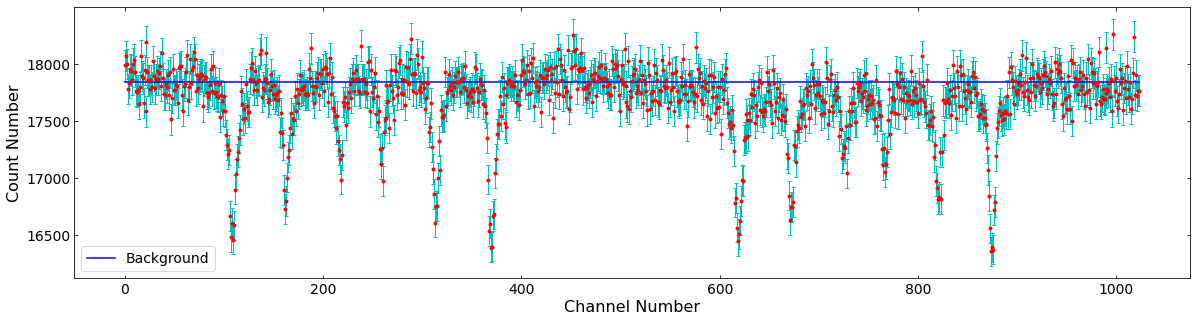

In [54]:
background_counts = np.mean(counts[0:50]+counts[450:550]+counts[950:])
plt.figure(figsize=(20,5))
plt.errorbar(channels, counts, yerr=np.sqrt(counts), fmt='.r', ecolor='c', elinewidth = 1, capsize=2) # poisson error
plt.plot(channels, [background_counts]*len(channels), '-b', label = 'Background')
plt.ylabel('Count Number', fontsize=16)
plt.xlabel('Channel Number', fontsize=16)
#plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tick_params(bottom=True, top=True, left=True, right=True, direction="in")
plt.legend(fontsize=14)
plt.show()

In [28]:
background_counts

17837.223214285714

# peak identification

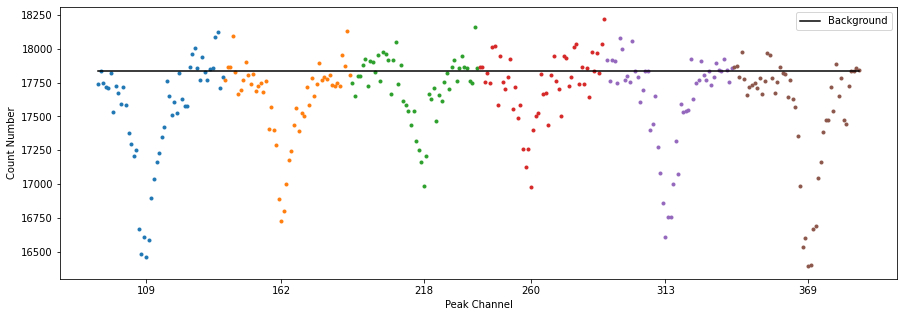

In [75]:

peak_channels_l = []

plt.figure(figsize=(15,5))
for i in range(90, 390, 50):
    plt.plot(channels[i:i+50],counts[i:i+50],'.')
    peak_channels_l.append(np.argmin(counts[i:i+50])+i)
plt.plot(channels[90:390], [background_counts]*300, '-k', label = 'Background')
plt.xticks(peak_channels_l)
plt.ylabel('Count Number')
plt.xlabel('Peak Channel')
plt.legend()
plt.show()

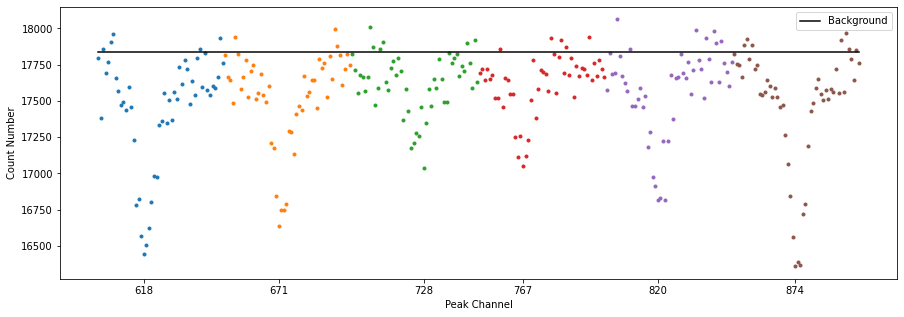

In [76]:
peak_channels_r = []
plt.figure(figsize=(15,5))
for i in range(600, 900, 50):
    plt.plot(channels[i:i+50],counts[i:i+50],'.')
    peak_channels_r.append(np.argmin(counts[i:i+50])+i)
plt.plot(channels[600:900], [background_counts]*300, '-k', label = 'Background')
plt.xticks(peak_channels_r)
plt.ylabel('Count Number')
plt.xlabel('Peak Channel')
plt.legend()
plt.show()

In [6]:
max_velocity_channel = []
for i in range(0,6,1):
    max_velocity_channel.append((peak_channels_l[i]+peak_channels_r[5-i])/2)
mid_point = np.mean(max_velocity_channel)

# Converting channels to energy

In [7]:
# velocity in unit of mini meter per second [mm/s]
# energy in unit of electron volt [eV]
velocity_channels=[]
energy_channels=[]
for x in channels:
    velocity_channels.append(10.22-abs(x-mid_point)*(10.22+9.59)/499)
for v in velocity_channels:
    energy_channels.append(v*14.4/(299792458))

# Channel plots

## Gaussian fit with background

In [8]:
def gaussian_background(x, bg, mu0, mu1, mu2, mu3, mu4, mu5, sigma0, sigma1, sigma2, sigma3, sigma4, sigma5, amp0, amp1, amp2, amp3, amp4, amp5):
    return bg+amp0*np.exp(((x-mu0)/sigma0)**2 /(-2))/((2*np.pi)**(0.5)*sigma0) \
            +amp1*np.exp(((x-mu1)/sigma1)**2 /(-2))/((2*np.pi)**(0.5)*sigma1) \
            +amp2*np.exp(((x-mu2)/sigma2)**2 /(-2))/((2*np.pi)**(0.5)*sigma2) \
            +amp3*np.exp(((x-mu3)/sigma3)**2 /(-2))/((2*np.pi)**(0.5)*sigma3) \
            +amp4*np.exp(((x-mu4)/sigma4)**2 /(-2))/((2*np.pi)**(0.5)*sigma4) \
            +amp5*np.exp(((x-mu5)/sigma5)**2 /(-2))/((2*np.pi)**(0.5)*sigma5)

In [9]:
def gaussian_fit_background(channels = channels[492:992], counts = counts[492:992], peak_channels = peak_channels_r, x_label = 'Energy Shift [Channels]'):
    # initialize
    plt.figure(figsize=(15,5))
    mean_list = []
    sdeviation_list = []
    amp_list = []
    background_noise = np.mean(counts)
    
    # iterate around each peak
    for i_peak in peak_channels:
        # initialize
        if i_peak > 500:
            i_peak = i_peak - 492
        xdata = np.array(channels[i_peak-30:i_peak+30])
        ydata = np.array(counts[i_peak-30:i_peak+30])
        mean = sum(xdata * ydata) / sum(ydata)
        sdeviation = np.sqrt(sum(ydata * (xdata - mean)**2) / sum(ydata))
        amplitude = min(ydata)-background_noise
        
        # record test parameters
        mean_list.append(mean)
        sdeviation_list.append(sdeviation)
        amp_list.append(amplitude)
    
    # curve fit
    popt, pcov = curve_fit(gaussian_background, np.array(channels), np.array(counts), \
                    p0=[background_noise, *mean_list, *sdeviation_list, *amp_list])

    # plot
    # squareroot error for counts
    plt.errorbar(channels, counts, yerr = np.sqrt(counts), fmt='.r', ecolor='c', elinewidth = 1, capsize=2)
    plt.plot(channels, gaussian_background(channels, *popt), color='b')
    
    plt.xticks(popt[1:7])
    plt.xlabel(x_label)
    plt.ylabel('Counts')
    #plt.legend()
    plt.show()
    return popt

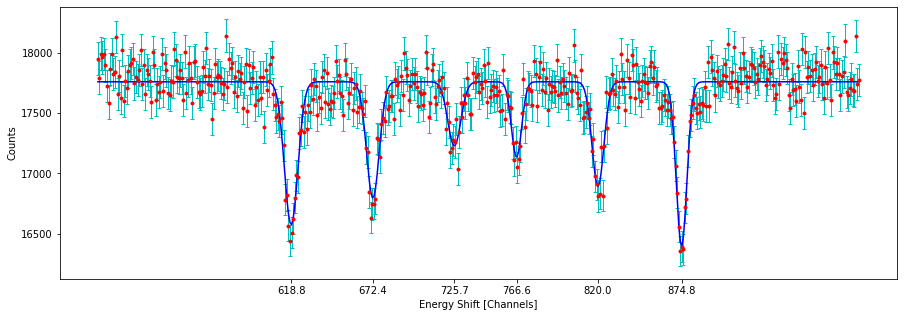

  Mean [Channels]    Standard Deviation [Channels]    Amplitude[Counts]
-----------------  -------------------------------  -------------------
          618.761                          4.42975            -13152.5
          672.353                          4.14249            -10006.7
          725.736                          4.2923              -5714.79
          766.563                          3.33139             -5225.23
          819.955                          3.92048             -8520.36
          874.779                          3.51332            -11993.2


In [10]:
gauss_fit_result = gaussian_fit_background()
print(tabulate({'Mean [Channels]':gauss_fit_result[1:7],'Standard Deviation [Channels]':gauss_fit_result[7:13],'Amplitude[Counts]':gauss_fit_result[13:19]}, headers='keys'))

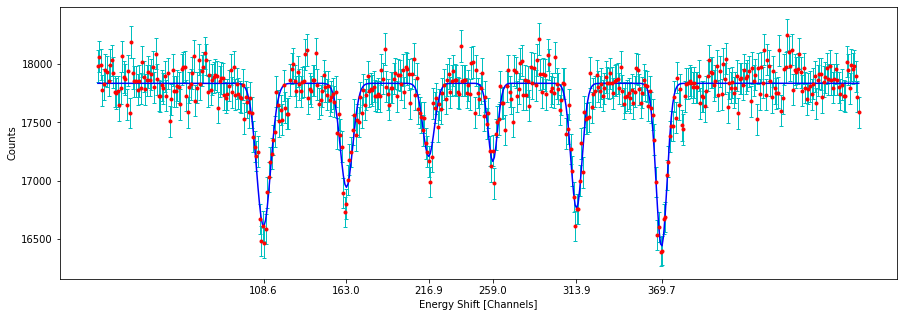

  Mean [Channels]    Standard Deviation [Channels]    Amplitude[Counts]
-----------------  -------------------------------  -------------------
          108.646                          4.57091            -14066.6
          162.993                          4.11442             -9217.54
          216.929                         -3.76684              5934.04
          258.988                          3.0926              -5205.91
          313.871                          3.70718             -9992.4
          369.655                          3.60777            -12691.4


In [69]:
gauss_fit_result_left = gaussian_fit_background(channels = channels[0:500], counts = counts[0:500], peak_channels = peak_channels_l)
print(tabulate({'Mean [Channels]':gauss_fit_result_left[1:7],'Standard Deviation [Channels]':gauss_fit_result_left[7:13],'Amplitude[Counts]':gauss_fit_result_left[13:19]}, headers='keys'))

In [72]:
sum_mid_points=[]
for i in range(1,7):
    sum_mid_points.append(gauss_fit_result[i]+gauss_fit_result_left[7-i])
np.mean(sum_mid_points)/2

492.4355956106076

In [74]:
mid_point

492.4166666666667

In [11]:
peak_channels_gauss = [round(x) for x in gauss_fit_result[1:7]]

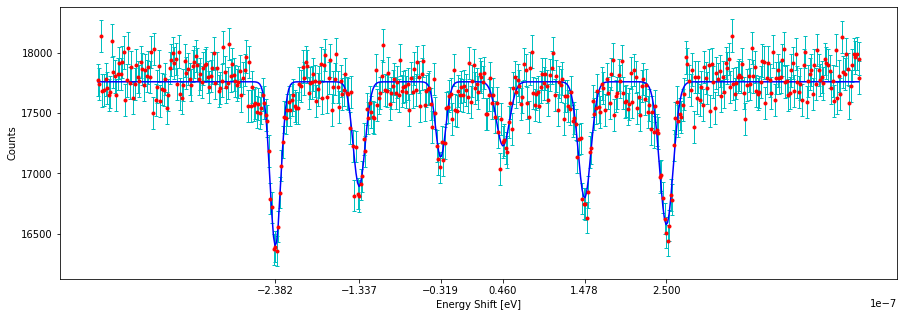

   Mean [eV]    Standard Deviation [eV]    Amplitude[Counts]
------------  -------------------------  -------------------
 2.49975e-07                8.44733e-09         -2.5081e-05
 1.47781e-07                7.9005e-09          -1.90833e-05
 4.59852e-08                8.18518e-09         -1.08978e-05
-3.18664e-08                6.35522e-09         -9.96612e-06
-1.3368e-07                 7.47617e-09         -1.62478e-05
-2.38223e-07                6.69962e-09         -2.287e-05


In [12]:
gauss_fit_result_energy = gaussian_fit_background(channels = energy_channels[492:992], peak_channels = peak_channels_gauss, x_label = 'Energy Shift [eV]')
print(tabulate({'Mean [eV]':gauss_fit_result_energy[1:7],'Standard Deviation [eV]':gauss_fit_result_energy[7:13],'Amplitude[Counts]':gauss_fit_result_energy[13:19]}, headers='keys'))

## Gaussian fit without background

In [13]:
def gaussian_single(x, bg, mu, sigma, amp):
    return bg+amp*np.exp(((x-mu)/sigma)**2 /(-2))/((2*np.pi)**(0.5)*sigma)

In [14]:
def gaussian_individual_peak(channels = channels[492:992], counts = counts[492:992], peak_channels = peak_channels_gauss, x_label = 'Energy Shift [Channels]'):
    # initialize
    plt.figure(figsize=(15,5))
    mean_list = []
    sd_list = []
    amp_list=[]
    background_noise = np.mean(counts)
    
    # squareroot error for counts
    plt.errorbar(channels, counts, yerr = np.sqrt(counts), fmt='.r', ecolor='c', elinewidth = 1, capsize=2)
    
    # iterate around each peak
    for i_peak in peak_channels:
        # initialize
        if i_peak > 500:
            i_peak = i_peak - 492
        sigma_range = 4*4
        xdata = np.array(channels[i_peak-sigma_range:i_peak+sigma_range])
        ydata = np.array(counts[i_peak-sigma_range:i_peak+sigma_range])
        mean = sum(xdata * ydata) / sum(ydata)
        sdeviation = np.sqrt(sum(ydata * (xdata - mean)**2) / sum(ydata))
        amplitude = min(ydata)-background_noise

        # curve fit
        popt, pcov = curve_fit(gaussian_single, xdata, ydata, p0=[background_noise, mean, sdeviation, amplitude])
        
        # plot
        plt.plot(xdata, gaussian_single(xdata, *popt), label='$\sigma$ = '+str(popt[2]))
        
        # record mean and standard deviation
        mean_list.append(popt[1])
        sd_list.append(popt[2])
        amp_list.append(popt[3])

    plt.xticks(mean_list)
    plt.xlabel(x_label)
    plt.ylabel('Counts')
    plt.legend()
    plt.show()
    return mean_list, sd_list, amp_list

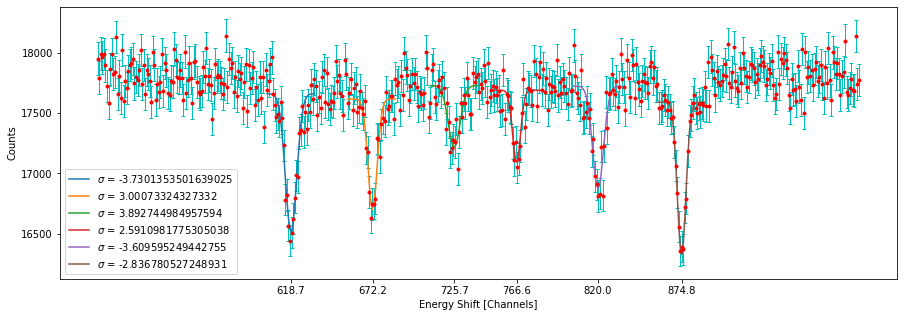

  Mean [Channels]    Standard Deviation [Channels]    Amplitude[Counts]
-----------------  -------------------------------  -------------------
          618.672                         -3.73014             10701
          672.16                           3.00073             -6871.13
          725.682                          3.89274             -5000.44
          766.582                          2.5911              -3920.98
          820.013                         -3.6096               7697.66
          874.81                          -2.83678              8990.58


In [15]:
single_gauss_result=gaussian_individual_peak()
print(tabulate({'Mean [Channels]':single_gauss_result[0],'Standard Deviation [Channels]':single_gauss_result[1],'Amplitude[Counts]':single_gauss_result[2]}, headers='keys'))

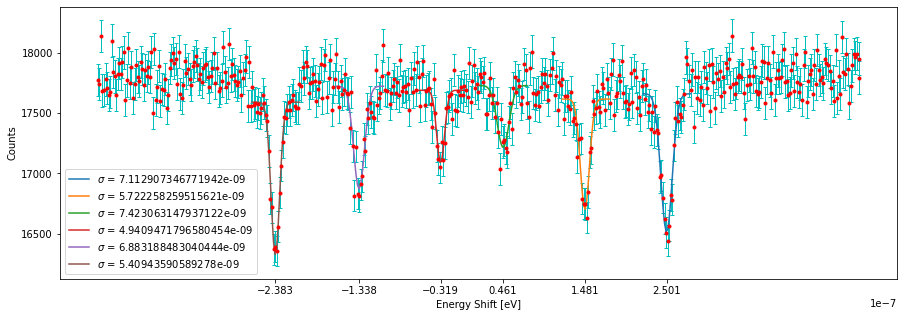

   Mean [eV]    Standard Deviation [eV]    Amplitude[Counts]
------------  -------------------------  -------------------
 2.50145e-07                7.11291e-09         -2.04055e-05
 1.48148e-07                5.72226e-09         -1.31028e-05
 4.60883e-08                7.42306e-09         -9.53532e-06
-3.1903e-08                 4.94095e-09         -7.47689e-06
-1.3379e-07                 6.88319e-09         -1.46787e-05
-2.38283e-07                5.40944e-09         -1.71441e-05


In [16]:
single_gauss_result_energy = gaussian_individual_peak(channels = energy_channels[492:992], peak_channels = peak_channels_gauss, x_label = 'Energy Shift [eV]')
print(tabulate({'Mean [eV]':single_gauss_result_energy[0],'Standard Deviation [eV]':single_gauss_result_energy[1],'Amplitude[Counts]':single_gauss_result_energy[2]}, headers='keys'))

## Lorentzian fit with background

In [17]:
def lorentzian_background(x, bg, mu0, mu1, mu2, mu3, mu4, mu5, gamma0, gamma1, gamma2, gamma3, gamma4, gamma5, amp0, amp1, amp2, amp3, amp4, amp5):
    return bg + (amp0 / np.pi) * (gamma0 / 2) / ((x - mu0)**2 + (gamma0 / 2)**2) \
            + (amp1 / np.pi) * (gamma1 / 2) / ((x - mu1)**2 + (gamma1 / 2)**2) \
            + (amp2 / np.pi) * (gamma2 / 2) / ((x - mu2)**2 + (gamma2 / 2)**2) \
            + (amp3 / np.pi) * (gamma3 / 2) / ((x - mu3)**2 + (gamma3 / 2)**2) \
            + (amp4 / np.pi) * (gamma4 / 2) / ((x - mu4)**2 + (gamma4 / 2)**2) \
            + (amp5 / np.pi) * (gamma5 / 2) / ((x - mu5)**2 + (gamma5 / 2)**2)

In [63]:
def lorentzian_fit_background(channels = channels[492:992], counts = counts[492:992], peak_channels = peak_channels_r, x_label = 'Energy Shift [Channels]'):
    # initialize
    plt.figure(figsize=(15,5))
    mean_list = []
    sdeviation_list = []
    amp_list = []
    background_noise = np.mean(counts)
    
    # iterate around each peak
    for i_peak in peak_channels:
        # initialize
        if i_peak > 500:
            i_peak = i_peak - 492
        xdata = np.array(channels[i_peak-30:i_peak+30])
        ydata = np.array(counts[i_peak-30:i_peak+30])
        mean = sum(xdata * ydata) / sum(ydata)
        sdeviation = np.sqrt(sum(ydata * (xdata - mean)**2) / sum(ydata))
        amplitude = min(ydata)-background_noise
        
        # record test parameters
        mean_list.append(mean)
        sdeviation_list.append(sdeviation)
        amp_list.append(amplitude)
    
    # curve fit
    popt, pcov = curve_fit(lorentzian_background, np.array(channels), np.array(counts), \
                    p0=[background_noise, *mean_list, *sdeviation_list, *amp_list])

    # plot
    # squareroot error for counts
    plt.errorbar(channels, counts, yerr = np.sqrt(counts), fmt='.r', ecolor='c', elinewidth = 1, capsize=2)
    plt.plot(channels, lorentzian_background(channels, *popt), color='b', label = 'Lorentzian fit')
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tick_params(bottom=True, top=True, left=True, right=True, direction="in")
    
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel('Counts', fontsize=14)
    plt.legend(fontsize=14)
    plt.show()
    return popt

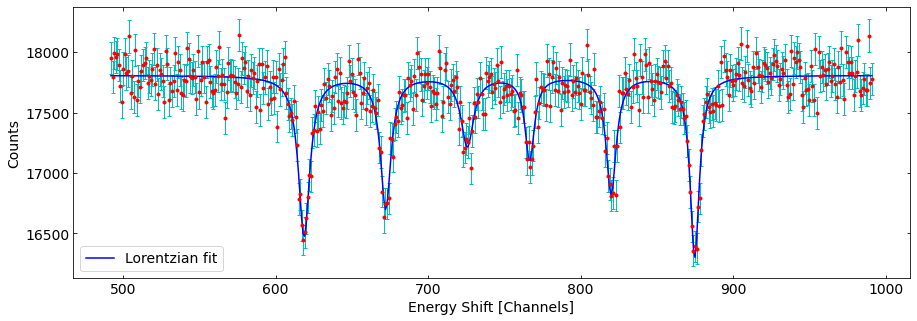

  Mean [Channels]    Half-Width [Channels]    Amplitude[Counts]
-----------------  -----------------------  -------------------
          618.658                  9.05477            -18934.7
          672.172                  8.356              -14399
          725.668                 10.004               -9092
          766.568                  7.44104             -8117.86
          820                      8.02545            -12312.2
          874.814                  7.35514            -17368.9


In [64]:
lorentz_fit_result = lorentzian_fit_background()
print(tabulate({'Mean [Channels]':lorentz_fit_result[1:7],'Half-Width [Channels]':lorentz_fit_result[7:13],'Amplitude[Counts]':lorentz_fit_result[13:19]}, headers='keys'))

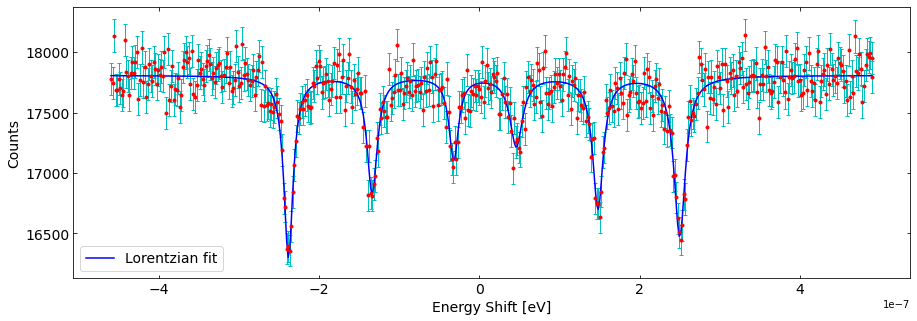

   Mean [eV]    Half-Width [eV]    Amplitude[Counts]
------------  -----------------  -------------------
 2.50172e-07        1.72665e-08         -3.61064e-05
 1.48125e-07        1.59344e-08         -2.74578e-05
 4.61145e-08        1.90767e-08         -1.73376e-05
-3.18779e-08        1.41893e-08         -1.54799e-05
-1.33767e-07        1.53037e-08         -2.3478e-05
-2.3829e-07         1.40255e-08         -3.31206e-05


In [65]:
peak_channels_lorentz = [round(x) for x in lorentz_fit_result[1:7]]
lorentz_fit_result_energy = lorentzian_fit_background(channels = energy_channels[492:992], peak_channels = peak_channels_lorentz, x_label='Energy Shift [eV]')
print(tabulate({'Mean [eV]':lorentz_fit_result_energy[1:7],'Half-Width [eV]':lorentz_fit_result_energy[7:13],'Amplitude[Counts]':lorentz_fit_result_energy[13:19]}, headers='keys'))

## Lorentzian fit without background

In [21]:
def lorentzian_single(x, bg, mu, gamma, amp):
    return bg + (amp / np.pi) * (gamma / 2) / ((x - mu)**2 + (gamma / 2)**2)

In [22]:
def lorentzian_individual_peak(channels = channels[492:992], counts = counts[492:992], peak_channels = peak_channels_lorentz, x_label='Energy Shift [Channels]'):
    # initialize
    plt.figure(figsize=(15,5))
    mean_list = []
    sd_list = []
    amp_list=[]
    background_noise = np.mean(counts)
    
    # squareroot error for counts
    plt.errorbar(channels, counts, yerr = np.sqrt(counts), fmt='.r', ecolor='c', elinewidth = 1, capsize=2)
    
    # iterate around each peak
    for i_peak in peak_channels:
        # initialize
        if i_peak > 500:
            i_peak = i_peak - 492
        sigma_range = 4*4
        xdata = np.array(channels[i_peak-sigma_range:i_peak+sigma_range])
        ydata = np.array(counts[i_peak-sigma_range:i_peak+sigma_range])
        mean = sum(xdata * ydata) / sum(ydata)
        sdeviation = np.sqrt(sum(ydata * (xdata - mean)**2) / sum(ydata))
        amplitude = min(ydata)-background_noise

        # curve fit
        popt, pcov = curve_fit(lorentzian_single, xdata, ydata, p0=[background_noise, mean, sdeviation, amplitude])
        
        # plot
        plt.plot(xdata, lorentzian_single(xdata, *popt), label='$\Gamma$ = '+'{:.3e}'.format(popt[2]))
        
        # record mean and standard deviation
        mean_list.append(popt[1])
        sd_list.append(popt[2])
        amp_list.append(popt[3])

    
    #plt.xticks(mean_list)
    plt.xlabel(x_label)
    plt.ylabel('Counts')
    plt.legend()
    plt.show()
    return mean_list, sd_list, amp_list

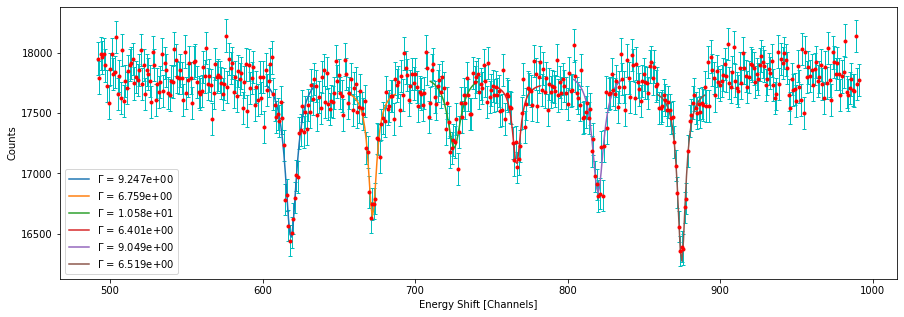

  Mean [Channels]    Half-Width [Channels]    Amplitude[Counts]
-----------------  -----------------------  -------------------
          618.671                  9.24679            -19893.8
          672.096                  6.75888            -11305.2
          725.704                 10.5773             -10191.7
          766.59                   6.40108             -6852.61
          819.986                  9.04945            -14420.6
          874.812                  6.51941            -14779.4


In [23]:
single_lorentz_result=lorentzian_individual_peak()
print(tabulate({'Mean [Channels]':single_lorentz_result[0],'Half-Width [Channels]':single_lorentz_result[1],'Amplitude[Counts]':single_lorentz_result[2]}, headers='keys'))

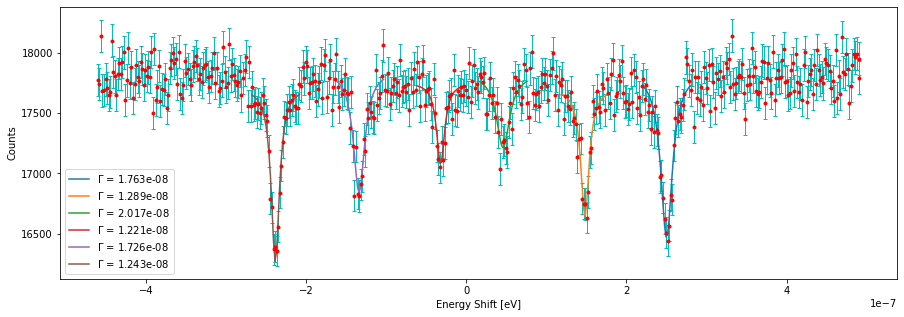

  Mean [Channels]    Half-Width [eV]    Amplitude[Counts]
-----------------  -----------------  -------------------
      2.50147e-07        1.76325e-08         -3.79349e-05
      1.48271e-07        1.28885e-08         -2.15579e-05
      4.60457e-08        2.01709e-08         -1.94357e-05
     -3.19186e-08        1.22058e-08         -1.30668e-05
     -1.33738e-07        1.72568e-08         -2.74991e-05
     -2.38285e-07        1.24317e-08         -2.81825e-05


In [24]:
single_lorentz_result_energy = lorentzian_individual_peak(channels = energy_channels[492:992], peak_channels = peak_channels_lorentz, x_label = 'Energy Shift [eV]')
print(tabulate({'Mean [Channels]':single_lorentz_result_energy[0],'Half-Width [eV]':single_lorentz_result_energy[1],'Amplitude[Counts]':single_lorentz_result_energy[2]}, headers='keys'))

In [25]:
test_tuple=(1,2,3)

In [26]:
test_tuple[1]

2